##############################################################################
##############################################################################
### **Atelier "Comprendre et développer des CNN pour le traitement d'images"**
##############################################################################
##############################################################################
<br>
<br>
<br>
<br>

#### **Partie 2 : Développement d'un CNN de classification d'images satellitaires from scratch** 



Dans cette deuxième partie, nous allons développer un modèle CNN "from scratch, afin de classifier correctement des images satellitaires de 4 types : désert, foret, océan et nuageux
<br>
<br>
<br>
<br>

############################################################






<br>
<br>

#### **Import des librairies utiles pour l'atelier**

L'atelier se base sur **Pytorch**, un framework qui a énormément gagné en popularité ces dernières années. 

**TorchVision** est lui un package spécialement tourné vers la Computer Vision, et permet l'accès facile à des datasets publics, de créer aisement ses propres datasets. Il contient aussi nativement les principaux modèlesde fondation Open-Source, comme nous le verrons plus tard.
<br>

In [36]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt

#### **Vérification de la présence de capacité de calcul GPU sur l'ordinateur**

In [37]:
# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {device}")

Using device: cpu



<br>

#### **Etape 1 : chargement du Dataset et transformation des données pour qu'elles soient utilisables par un modèle CNN**



Nous allons maintenant transformer les images pour qu'elles aient : 
- La taille requise pour être entrée dans le modèle : 128 pixels par 128 pixels
- Un format qui soit un tensor Pytorch, afin d'être intégré au Pipeline Pytorch
- Une normalisation des données des images sur les 3 canaux, R, G et B. On choisit ici une moyenne de 0.5 et une std associée de 0.5


Nous allons utiliser l'utilitaire **Transforms de TorchVision** qui va automatiser le pré-traitement des datasets
<br>



In [38]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images
    transforms.ToTensor(),          # Convert images to tensors
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1, 1]
])

<br>

#### **Chargement du Dataset avec l'utilitaire datasets de TorchVision**

TorchVision permet de manipuler de manière optimale les datasets, en leur appliquant des pipelines de transformation en optimisant le temps de calcul

La seule obligation est de fournir un répertoire où les images doivent être mises dans des dossiers contenant le nom des labels. Ces noms de dossier deviendront automatiquement les classes d'apprentissage

<br>


In [39]:
# Paths
data_dir = "C:/Code_ML/Code/Atelier CNN/data/"

full_dataset = datasets.ImageFolder(root=data_dir, transform=transform)
print(f"Total Images: {len(full_dataset)}")
print(f"Classes: {full_dataset.classes}")

Total Images: 5631
Classes: ['cloudy', 'desert', 'green_area', 'water']



<br>

#### **Split du dataset**

Selon les bonnes pratiques du ML, nous allons spliter notre dataset en jeu de Train, Validation et Test. Nous allons ensuite les convertir en Loaders, qui permettront une manipulation optimale ultérieurement.


Le paramètre "Batch size" détermine la taille des batchs servant à itérer pour chaque mise à jour des poids.


On pourrait passer 1 image à la fois ou à l'inverse, tout le dataset, mais ce n'est pas optimal. Passer des batchs de taille adaptée permet de gagner en efficacité d'entrainemenet et en stabilité des gradients
<br>



In [40]:
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Train: {len(train_dataset)}, Validation: {len(val_dataset)}, Test: {len(test_dataset)}")


Train: 3941, Validation: 844, Test: 846


**Avant de créer le modèle, visualisations quelques échantillons aléatoires du dataset**

Sample images from training data:


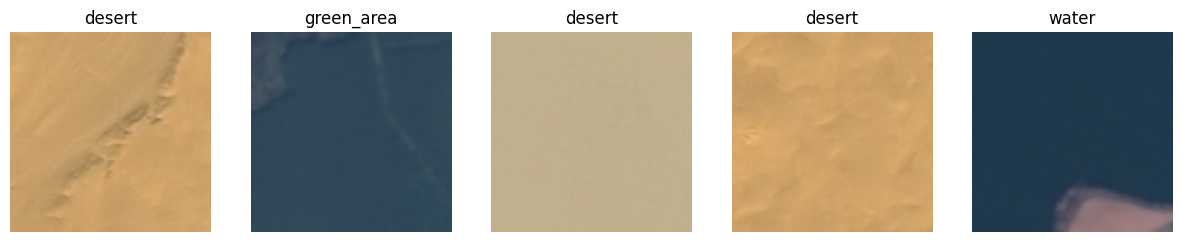

In [41]:
classes = full_dataset.classes

def show_images(loader):
    dataiter = iter(loader)
    images, labels = next(dataiter)
    fig, axes = plt.subplots(1, 5, figsize=(15, 5))
    for i in range(5):
        axes[i].imshow(images[i].permute(1, 2, 0) * 0.5 + 0.5)  # Un-normalize
        axes[i].set_title(classes[labels[i]])
        axes[i].axis('off')
    plt.show()

print("Sample images from training data:")
show_images(train_loader)


<br>

#### **Etape 2 : construction de l'architecture du CNN**


Nous allons maintenant constituer l'architecture de notre CNN.


Pour cela, Pytorch propose la définition d'un classe CNN dans lequel nous aurons définir 2 parties :
<br>

------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------
- **self.conv_layers** : dans laquelle nous allons ajouter de manière séquentielle les différentes strates de la partie convolutive du modèle avec leurs paramètres
    -   Exemple : **nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)**

                - couche de convolution avec 32 matrices de convolution de taille 3X3X3, l'image ayant 3 canaux. La couche aura donc en sortie 32 cartes de features issus des 32 matrices.

                - stride = 1: le noyau de convolution se déplace 1 pixel par 1 pixel, il n'y a pas de réduction de taille de l'image

                - padding = 1 : On rajoute 1 pixel en bord d'image pour que le passage du filtre ne réduise pas la taille de la sortie 

------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------          
- **self.fc_layers** : dans laquelle nous allons ajouter de manière séquentielle les différentes strates de la partie "fully connected" du modèle avec leurs paramètres. Généralement, on va aplatir les données en sortie de la partie conventionneles pour les transformer en vecteur unidimensionnel ("flatten") et ainsi pouvoir ajouter une couche de neurones totalement connectés, sur 1 ou plusieurs couches, jusqu'à la couche finale qui contient autant de neurons que le nombre de classes à prédire (4 dans notre cas)

<br>

La fonction forward est standard et indique l'ordre de propagation des données dans le modèle



In [42]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),  # Conv Layer 1
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Downsample by 2

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # Conv Layer 2
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # Conv Layer 3
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 256),  
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

**Instantiation du modèle**

In [43]:
model = CNN(num_classes=len(classes))
model = model.to(device)
print(model)

CNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=32768, out_features=256, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=256, out_features=4, bias=True)
  )
)


<br>

#### **Etape 3 : entrainement**


Nous allons maintenant procéder à l'entrainement du modèle.


Nous commencons par définir la métrique liée à la fonction de cout (ici l'entropie croisée)

<br>



In [44]:
criterion = nn.CrossEntropyLoss()



Nous définissons ensuite l'**optimizer**, le grand classique étant Adam.

Regardons le paramètre lr ou **learning rate**:
Ce paramètre détermine l'intensité de mise à jour des poids du modèle. Ceci signifie qu'un lr trop grand engendre de fortes variations et donc une forte instabilité, alors qu'un lr trop faible rendrait très lent l'apprentissage.

In [45]:
optimizer = optim.Adam(model.parameters(), lr=0.001)


Nous allons maintenant entrainer le modèle sur un certain nombre d'époques, ici définis à 5.


Lors de chaque époque, le modèle va s'entrainer sur tous les éléments du dataset de train, puis sera évalué sur le dataset de validation.

l'objet Model a 2 modes, le "training mode" enclenché par l'appel model.train() et le "validation mode, enclenché par l'appel model.eval().

2 élements clefs à comprendre :

- **lors de la première phase** :
    1. la "forward pass" se passe lorsque l'input est passée dans le modèle pour générer des outputs  :outputs = model(inputs)
    2. l'erreur est calculée : loss = criterion(outputs, labels)
    3. la retropropagation d'erreur suit : loss.backward()
    4. les poids du modèles sont mis à jour : optimizer.step() 
- **lors de la deuxième phase**, l'erreur sur le jeu de validation est calculé. Cette valeur sert exclusivement à observer du surapprentissage

In [ ]:
num_epochs = 5
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Training
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_accuracy = 100 * correct / total

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

KeyboardInterrupt: 

**Affichage des valeurs de loss et d'accuracy**

ValueError: x and y must have same first dimension, but have shapes (5,) and (0,)

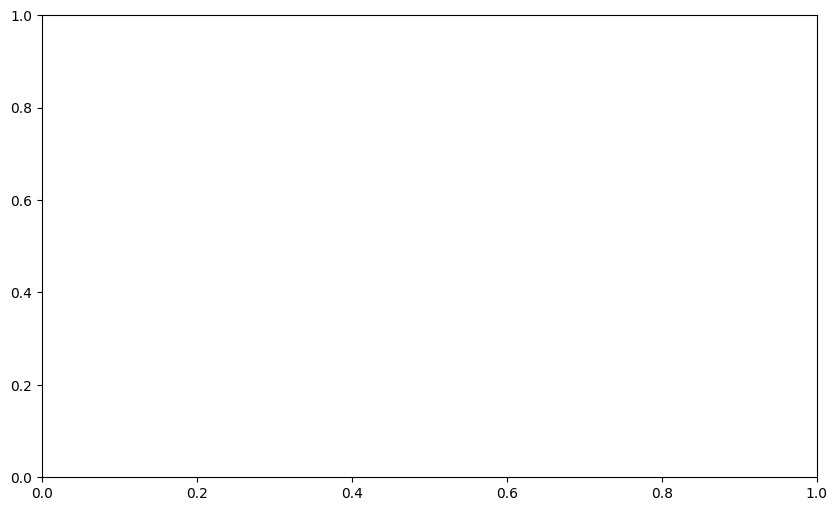

In [47]:
import matplotlib.pyplot as plt

# Plot validation losses
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), val_losses, marker='o', color='b', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()



<br>

#### **Etape 4 : Evaluation du modèle sur les données de Test, données extérieures à l'apprentissage**

<br>

In [48]:

model.eval()
test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_loss /= len(test_loader)
test_accuracy = 100 * correct / total

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

Test Loss: 0.3145, Test Accuracy: 89.60%


<br>
#### **Etape 5 : à vous de jouer !**

Prenez le temps d'étudier l'effet de différents paramètres :
- l'ajout d'une data augmentation
- la variation du batch size
- la variation du learning rate
- l'ajout de couches de convolution

<br>

**Question bonus** : pouvez-vous retrouver, à partir des caractéristiques du CNN initial et de sa première couche fully connected (nn.Linear(128 * 16 * 16, 256)), la nécessité d'avoir des images de format 128x128x3 en entrée?

<br>